In [2]:
import pandas as pd
import numpy as np

from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error, mean_absolute_error
from sklearn import neighbors

from matplotlib import pyplot as plt

import statsmodels
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.graphics.gofplots import qqplot

import glob
from os import path

from scipy import stats

import seaborn as sb

%matplotlib inline

In [3]:
def rlm_results(modification_type_pattern, column_filter):

   rownames = []
   results = []

   for fname in glob.glob(modification_type_pattern):
    
       data = pd.read_csv(fname, sep="\t")
       data = data[["chr", "begin", "end"]+[col for col in data.columns[3:] if column_filter(col)]]
       data = data.fillna(0)
      
       y = (data["end"]-data["begin"]).values
       X = data.iloc[:,3:].values
       X = np.hstack((X, np.ones((X.shape[0],1)))) # Adds constant factor.

       kf = KFold(len(y), n_folds=5, random_state=42)
       
       clf = RandomForestRegressor(n_estimators=100, n_jobs=2)
        
       scores = []
       y_test = []
       y_pred = []
       for train, test in kf:
           clf.fit(X[train], y[train])
           res = clf.predict(X[test])
           y_test += list(y[test])
           y_pred += list(res)
           scores.append(mean_absolute_error(y[test], res))
       
       plt.figure(figsize=(10,6))
       plt.plot([0, max(y_test)], [0, max(y_test)], color="red")  
       plt.scatter(y_test, y_pred, s=1)
       plt.xlim(0, max(y_test))
       plt.ylim(0, max(y_pred))
       plt.title(path.basename(fname))
       plt.show()

       rownames.append(path.basename(fname).split(".")[0])
       results.append((np.mean(scores), np.std(scores), stats.pearsonr(y_test, y_pred)[0],
                       stats.spearmanr(y_test, y_pred)[0]))

   return pd.DataFrame(results, index=rownames, columns = ["MAE", "MAE std", "Pearson R", "Spearman R"])

In [7]:
def rlm_results_chr(modification_type_pattern, column_filter):

   rownames = []
   results = []

   for fname in glob.glob(modification_type_pattern):
    
       data = pd.read_csv(fname, sep="\t")
       data = data[["chr", "begin", "end"]+[col for col in data.columns[3:] if column_filter(col)]]
       data = data.fillna(0)
      
       y = (data["end"]-data["begin"]).values
       X = data.iloc[:, 3:]
       X["chr"] = pd.factorize(data["chr"])[0]
       X = X.values
       
       kf = KFold(len(y), n_folds=5, random_state=42)
       
       clf = RandomForestRegressor(n_estimators=100, n_jobs=2)
        
       scores = []
       y_test = []
       y_pred = []
       for train, test in kf:
           clf.fit(X[train], y[train])
           res = clf.predict(X[test])
           y_test += list(y[test])
           y_pred += list(res)
           scores.append(mean_absolute_error(y[test], res))
       
       plt.figure(figsize=(10,6))
       plt.plot([0, max(y_test)], [0, max(y_test)], color="red")  
       plt.scatter(y_test, y_pred, s=1)
       plt.xlim(0, max(y_test))
       plt.ylim(0, max(y_pred))
       plt.title(path.basename(fname))
       plt.show()

       rownames.append(path.basename(fname).split(".")[0])
       results.append((np.mean(scores), np.std(scores), stats.pearsonr(y_test, y_pred)[0],
                       stats.spearmanr(y_test, y_pred)[0]))

   return pd.DataFrame(results, index=rownames, columns = ["MAE", "MAE std", "Pearson R", "Spearman R"])

# Prediction error

## Overlap with different markers

Random forest regression with 100 trees is performed on the data sets with features based on overlap with different markers.

Results for H3K4me3:

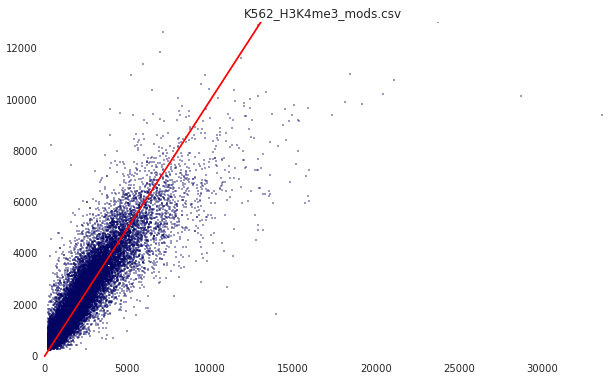

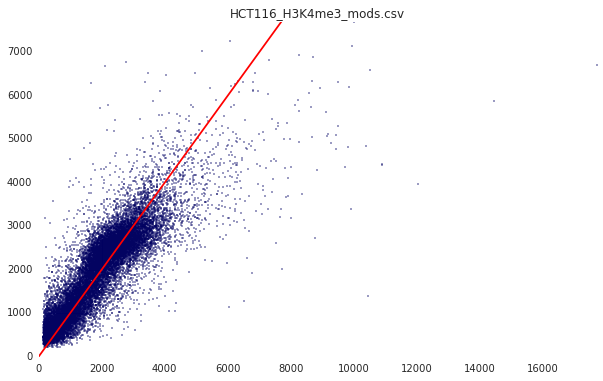

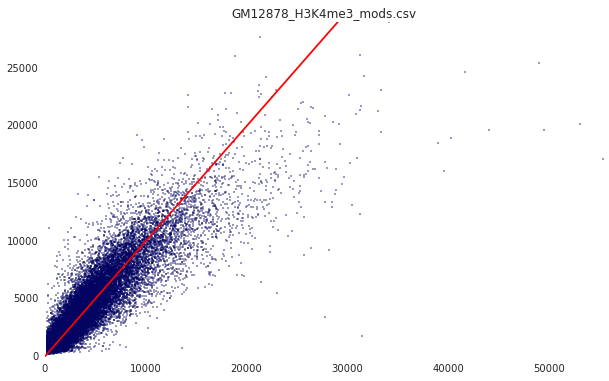

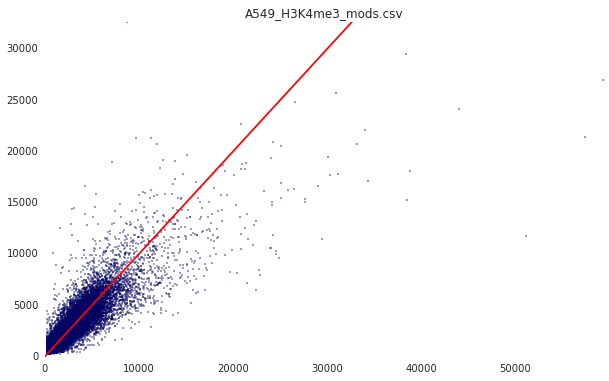

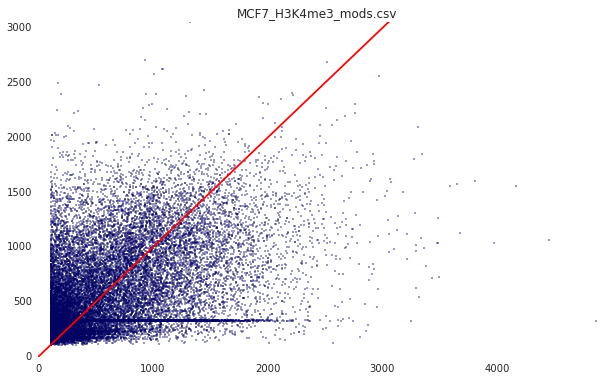

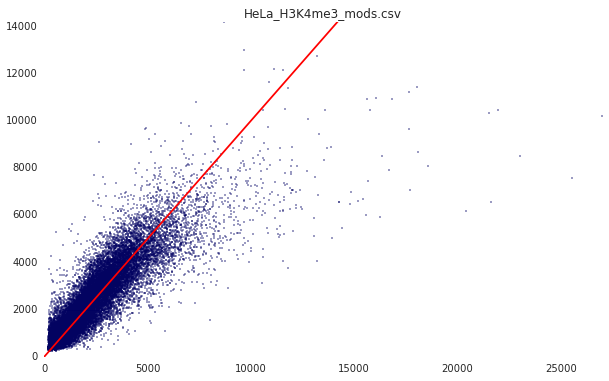

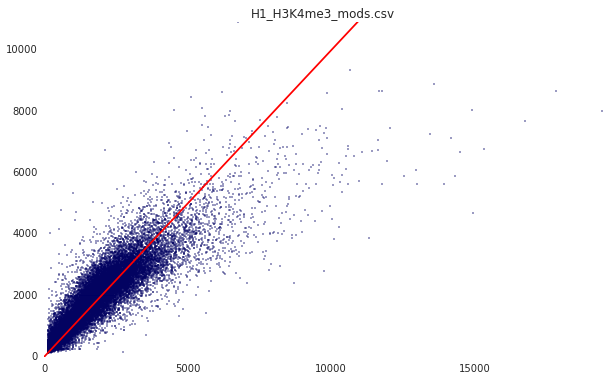

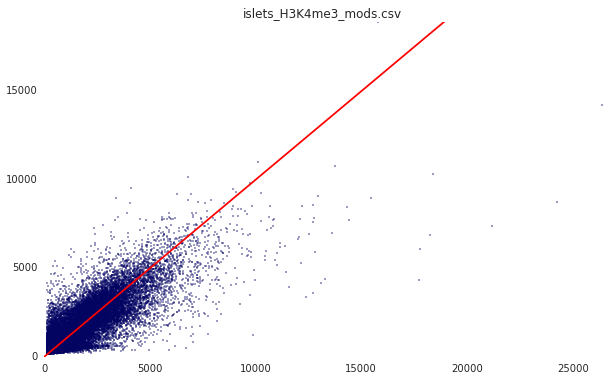

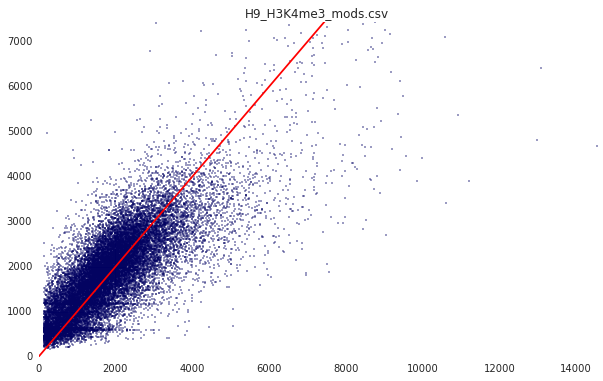

,MAE,MAE std,Pearson R,Spearman R
K562_H3K4me3_mods,526.096874,7.990981,0.886558,0.914459
HCT116_H3K4me3_mods,400.235974,5.698091,0.863454,0.891458
GM12878_H3K4me3_mods,715.938887,20.182570,0.911383,0.909551
A549_H3K4me3_mods,483.687573,13.100124,0.886467,0.920878
MCF7_H3K4me3_mods,260.077724,2.166487,0.535661,0.450289
HeLa_H3K4me3_mods,524.497660,23.334767,0.883079,0.911848
H1_H3K4me3_mods,444.500691,4.391526,0.870655,0.899624
islets_H3K4me3_mods,507.900535,11.039291,0.835563,0.785828
H9_H3K4me3_mods,539.082035,4.176032,0.782966,0.797699


In [3]:
rlm_results("../data/processed_peaks/*/*H3K4me3_mods.csv", lambda x: "ifreq" not in x)

Results for H3K27ac:

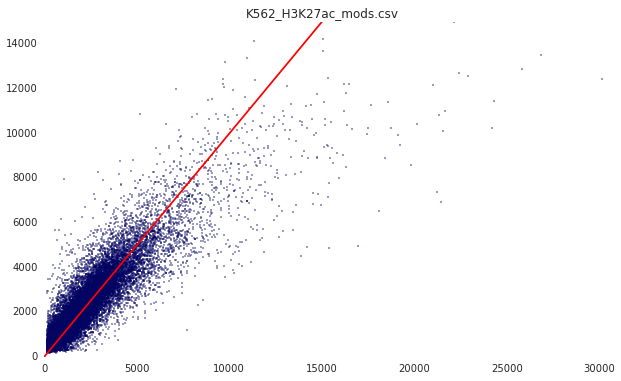

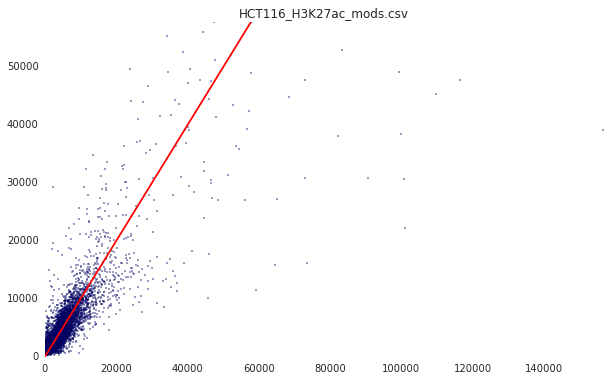

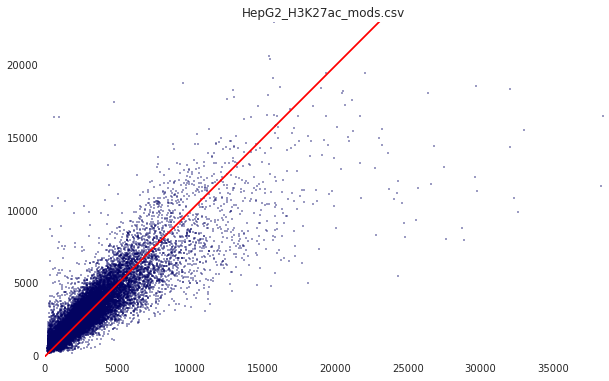

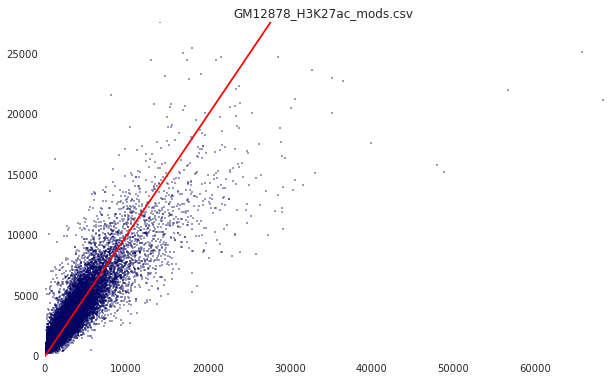

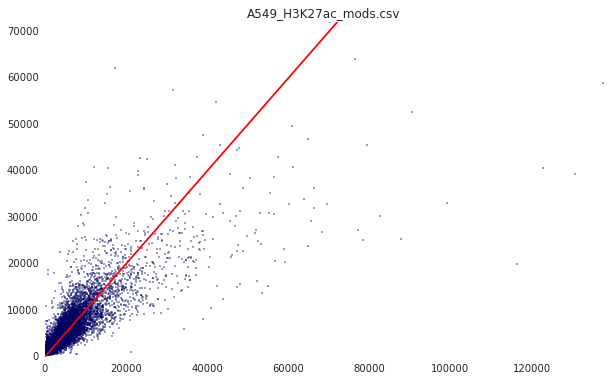

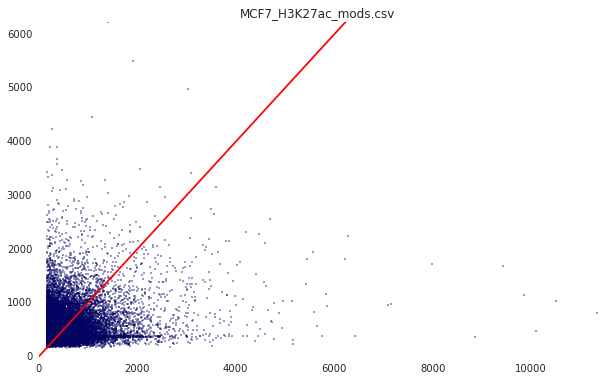

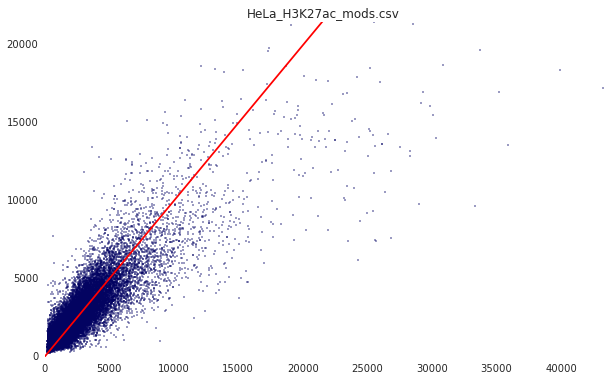

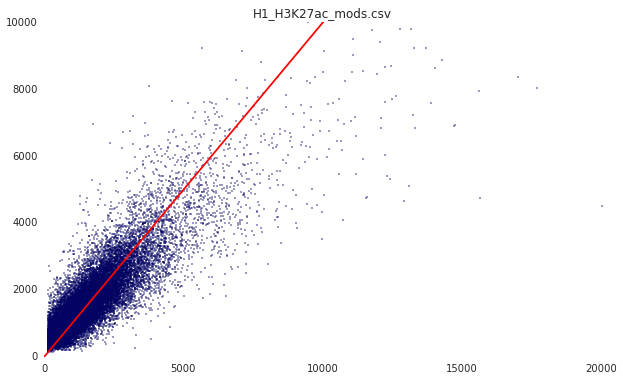

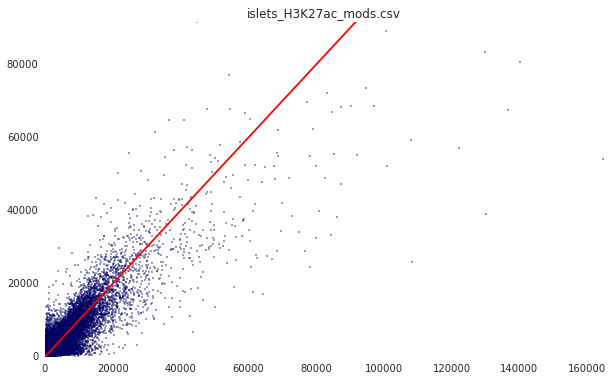

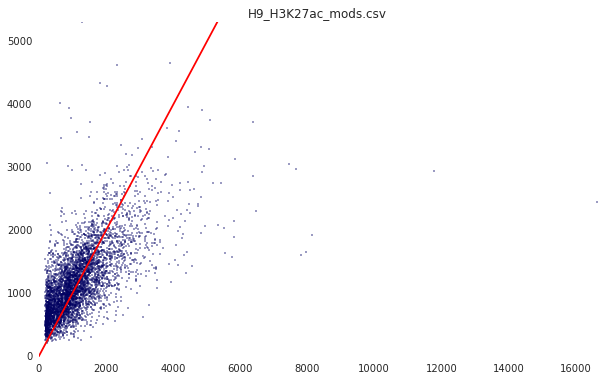

,MAE,MAE std,Pearson R,Spearman R
K562_H3K27ac_mods,515.802717,12.377613,0.893146,0.908701
HCT116_H3K27ac_mods,744.241269,20.730619,0.839934,0.860496
HepG2_H3K27ac_mods,686.727686,37.897181,0.872637,0.900013
GM12878_H3K27ac_mods,741.066941,12.178651,0.880964,0.896029
A549_H3K27ac_mods,851.357295,34.075967,0.849247,0.897925
MCF7_H3K27ac_mods,257.926082,4.537696,0.288562,0.242970
HeLa_H3K27ac_mods,676.915409,27.232822,0.862556,0.864421
H1_H3K27ac_mods,435.093089,10.190919,0.859950,0.847779
islets_H3K27ac_mods,950.239498,35.670319,0.872494,0.660483
H9_H3K27ac_mods,424.728946,13.768599,0.663658,0.703632


In [4]:
rlm_results("../data/processed_peaks/*/*H3K27ac_mods.csv", lambda x: "ifreq" not in x)

# With chromosome information

Results for H3K4me3:

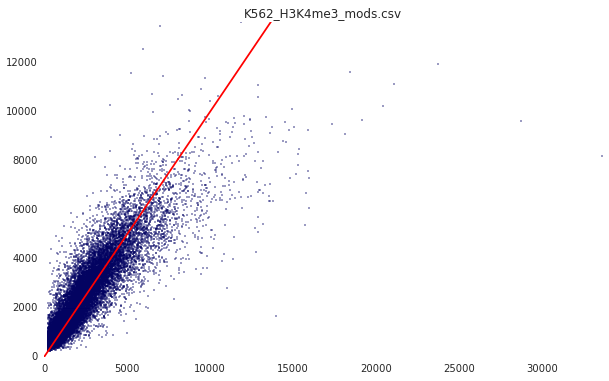

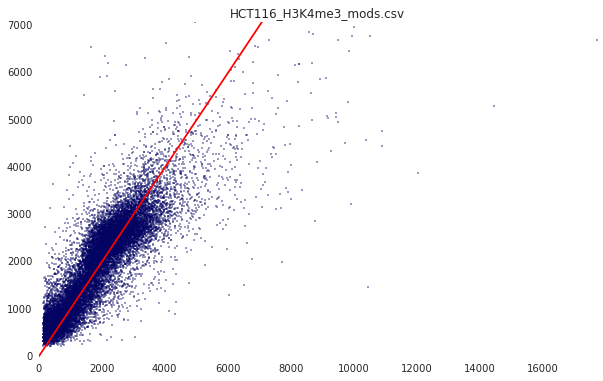

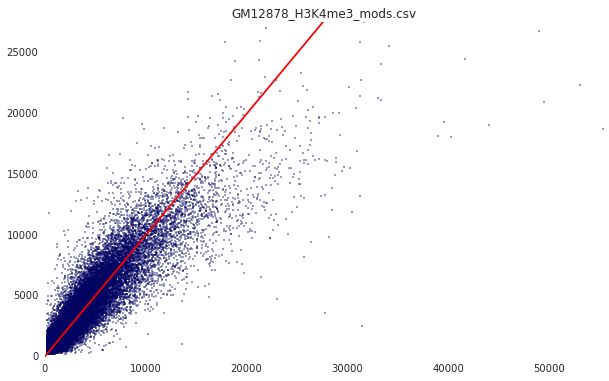

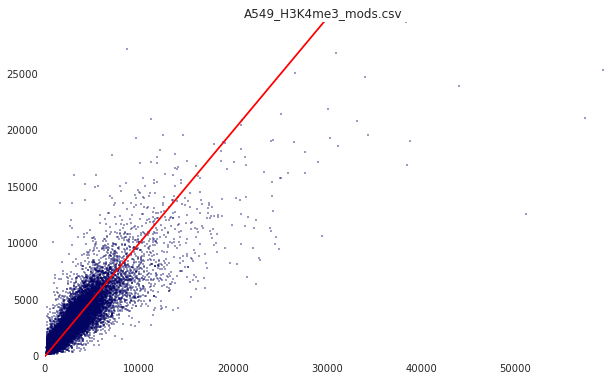

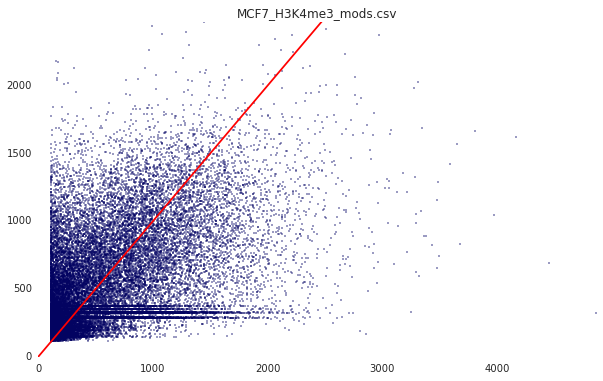

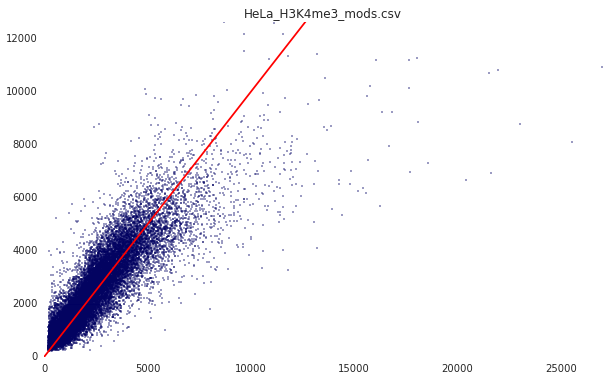

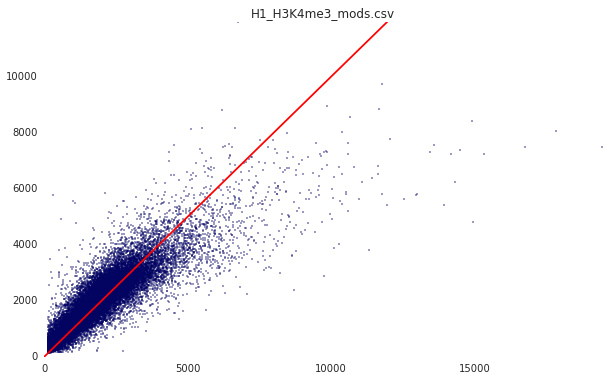

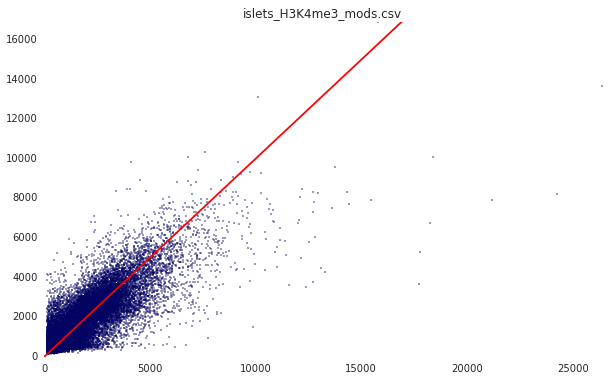

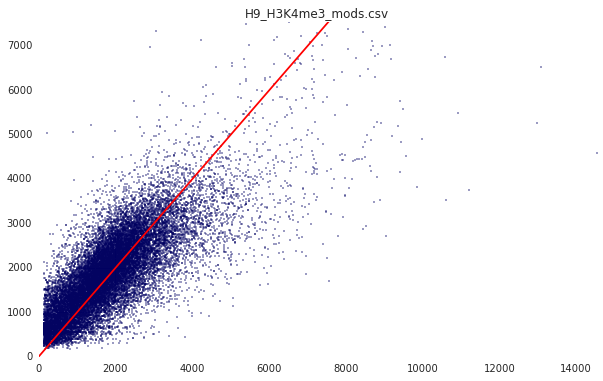

,MAE,MAE std,Pearson R,Spearman R
K562_H3K4me3_mods,530.753158,7.125556,0.884953,0.913368
HCT116_H3K4me3_mods,402.784540,5.390456,0.862641,0.890701
GM12878_H3K4me3_mods,722.479202,18.321853,0.911313,0.908227
A549_H3K4me3_mods,488.062374,10.568410,0.886874,0.919515
MCF7_H3K4me3_mods,254.375585,6.030149,0.555047,0.479730
HeLa_H3K4me3_mods,527.265350,21.785471,0.883473,0.911270
H1_H3K4me3_mods,447.556390,8.619706,0.870363,0.899588
islets_H3K4me3_mods,504.419040,13.073330,0.839375,0.790317
H9_H3K4me3_mods,544.013517,7.040641,0.780847,0.795625


In [8]:
rlm_results_chr("../data/processed_peaks/*/*H3K4me3_mods.csv", lambda x: "ifreq" not in x)

## Results for H3K27ac:

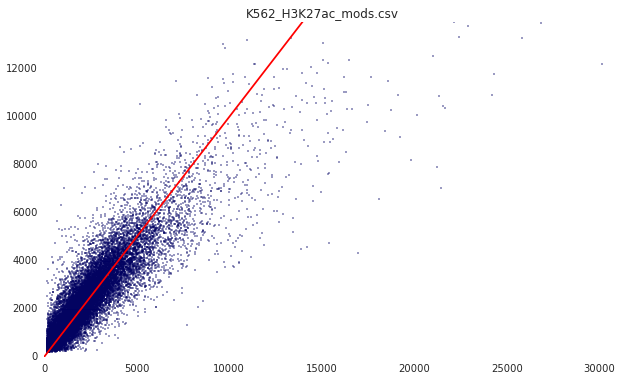

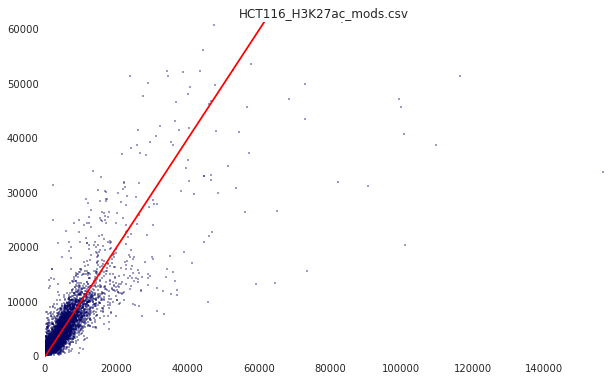

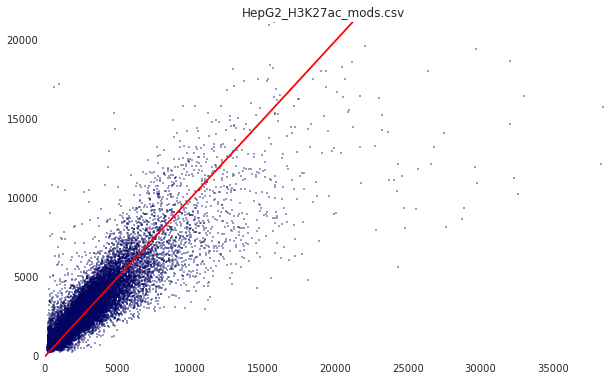

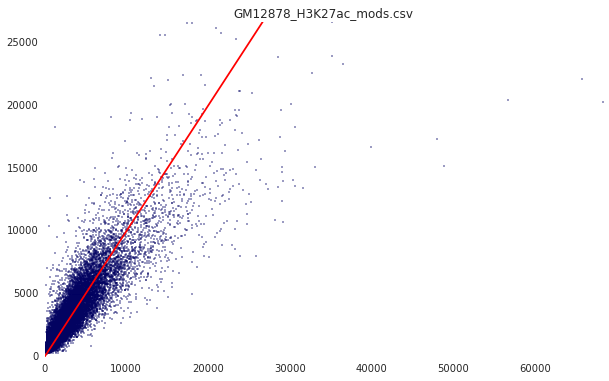

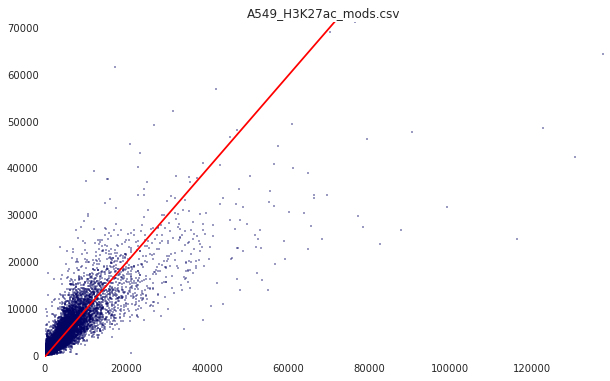

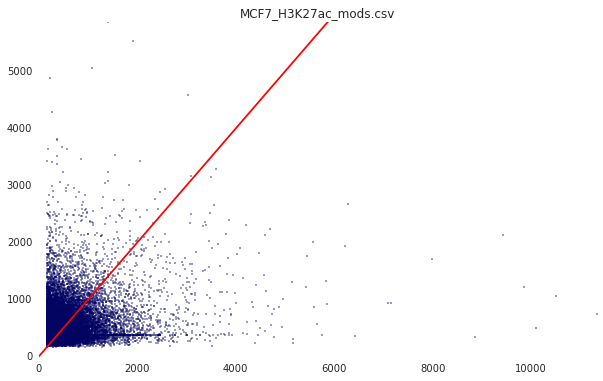

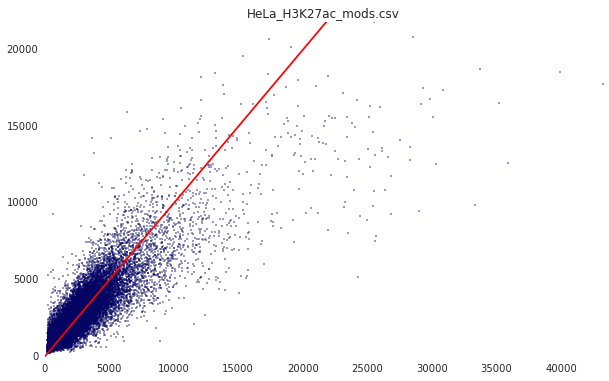

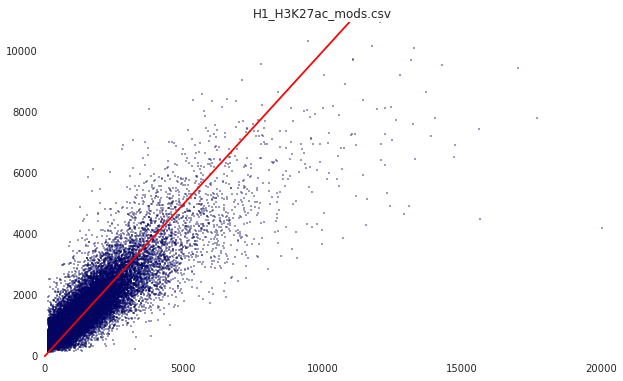

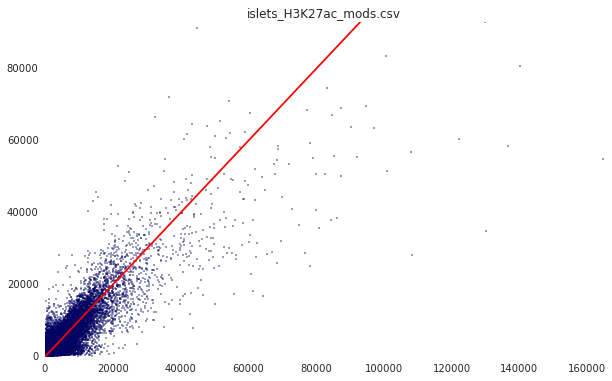

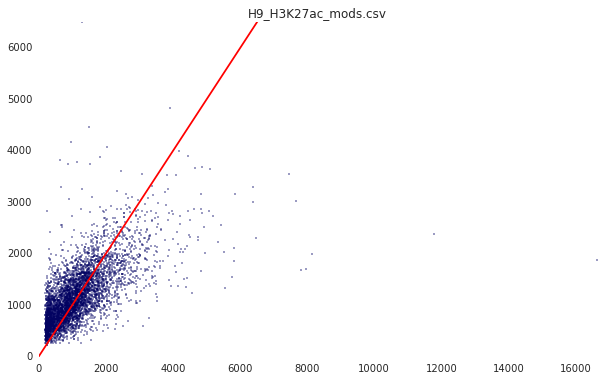

,MAE,MAE std,Pearson R,Spearman R
K562_H3K27ac_mods,516.535032,13.062240,0.893086,0.908549
HCT116_H3K27ac_mods,749.091654,16.721792,0.839543,0.859823
HepG2_H3K27ac_mods,687.285977,37.127411,0.872615,0.900429
GM12878_H3K27ac_mods,745.648571,17.220707,0.878506,0.895388
A549_H3K27ac_mods,850.038322,35.760066,0.852891,0.898101
MCF7_H3K27ac_mods,257.771295,4.295027,0.290825,0.244179
HeLa_H3K27ac_mods,677.738188,28.083356,0.861599,0.864542
H1_H3K27ac_mods,435.545745,8.879953,0.858985,0.847903
islets_H3K27ac_mods,948.740433,34.378160,0.872255,0.660851
H9_H3K27ac_mods,424.214465,13.283675,0.656268,0.704312


In [9]:
rlm_results("../data/processed_peaks/*/*H3K27ac_mods.csv", lambda x: "ifreq" not in x)